In [221]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt 
from scipy import signal
from scipy import optimize
from scipy import ndimage
from math import erf
plt.style.use('cashaback_dark')

Creating my own truncated normal class

In [86]:
class truncnorm():
    def __init__(self,x,cut_off_a,cut_off_b,mu,sig):
        self.x = x
        self.cut_off_a = cut_off_a
        self.cut_off_b = cut_off_b
        self.mu = mu
        self.sig = sig
        self.timing_sd = 3
    def norm_pdf(self):
        return (1/(self.sig*np.sqrt(2*np.pi)))*np.e**((-0.5)*((self.x-self.mu)/self.sig)**2)
    def norm_cdf(self):
        '''
        Cumulative distribution function for the standard normal distribution
        '''
        
        return (1.0 + erf(self.x / np.sqrt(2.0))) / 2.0
    
    def pdf(self):
        ans = np.zeros(len(self.x))
        a, b = (self.cut_off_a - self.mu)/self.sig, (self.cut_off_b - self.mu) / self.sig
        for i,r in enumerate(self.x):
            if r<=self.cut_off_a or r>=self.cut_off_b:
                ans[i] = 0
            else:
                N = ((stats.norm.pdf(r,self.mu,self.sig)))
                D = ((stats.norm.cdf(self.cut_off_b,self.mu,self.sig)) - (stats.norm.cdf(self.cut_off_a,self.mu,self.sig)))
                ans[i] = N
        return ans
    
    def pdf_uncertain(self):
        ans = np.zeros(len(self.x))
        a, b = (self.cut_off_a - self.mu)/self.sig, (self.cut_off_b - self.mu) / self.sig
        for i,r in enumerate(self.x):
            if r<=self.cut_off_a:
                ans[i] = 0
            elif r>=self.cut_off_b:
                N = stats.norm.pdf(r,self.mu,self.sig)
                # mean_diff = self.mu - self.cut_off_b
                # sigma_diff = np.sqrt(self.sig**2 + self.timing_sd**2)
                # self.prob_x_greater_b = 1 - stats.norm.cdf(0,mean_diff,sigma_diff)
                # ans[i] = N/D
                mean_diff = self.mu - self.cut_off_b
                sigma_diff = np.sqrt(self.sig**2 + self.timing_sd**2)
                self.prob_less_0 = stats.norm.cdf(0,mean_diff,sigma_diff) # Probablity that the random time selected is greater than the agent time selected
                self.certan_prob = stats.norm.cdf(self.cut_off_b,self.mu,self.sig)
                D = self.prob_less_0 - stats.norm.cdf(self.cut_off_a,self.mu,self.sig)
                ans[i] = N/(D)
            else:
                N = (stats.norm.pdf(r,self.mu,self.sig))
                mean_diff = self.mu - self.cut_off_b
                sigma_diff = np.sqrt(self.sig**2 + self.timing_sd**2)
                self.prob_less_0 = stats.norm.cdf(0,mean_diff,sigma_diff) # Probablity that the random time selected is greater than the agent time selected
                self.certan_prob = stats.norm.cdf(self.cut_off_b,self.mu,self.sig)
                D = self.prob_less_0 - stats.norm.cdf(self.cut_off_a,self.mu,self.sig)
                ans[i] = N/D
        return ans
    
    def cdf(self):
        ans = np.zeros(len(self.x))
        a, b = (self.cut_off_a - self.mu)/self.sig, (self.cut_off_b - self.mu) / self.sig
        for i,r in enumerate(self.x):
            if r <= self.cut_off_a: 
                ans[i] = 0
            elif r >= self.cut_off_b:
                ans[i] = 1
            else:
                N = ((stats.norm.cdf(r,self.mu,self.sig) - stats.norm.cdf(self.cut_off_a,self.mu,self.sig)))
                D = ((stats.norm.cdf(self.cut_off_b,self.mu,self.sig)) - (stats.norm.cdf(self.cut_off_a,self.mu,self.sig)))
                ans[i] = N/D
        return ans

UNcertain pdf check

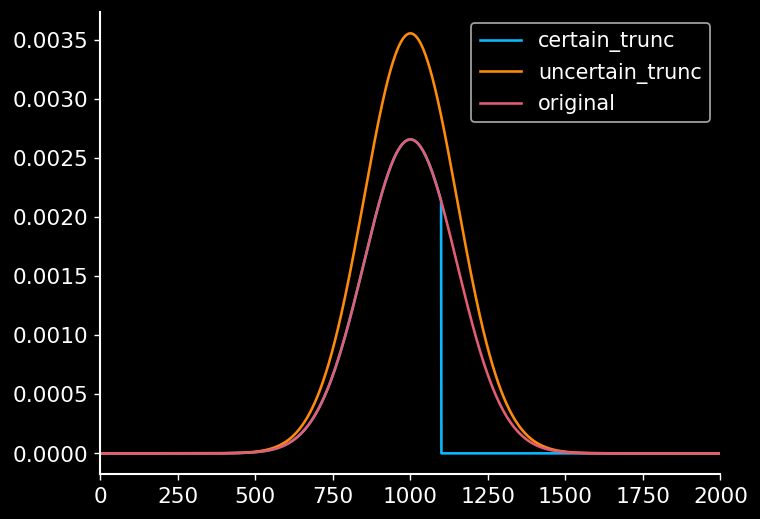

In [87]:
timesteps = np.arange(0,2000,1)
cut_off_a,cut_off_b = -2000,1100
mu,sig = 1000,150
original_agent_pdf = stats.norm.pdf(timesteps,mu,sig)
a, b = (cut_off_a - mu)/sig, (cut_off_b - mu) / sig
trunc = truncnorm(timesteps,cut_off_a,cut_off_b,mu,sig)
pdf_certain = trunc.pdf()

fig,ax = plt.subplots()
ax.plot(timesteps,pdf_certain,label='certain_trunc')
pdf_uncertain = trunc.pdf_uncertain()
ax.plot(timesteps,pdf_uncertain,label='uncertain_trunc')
ax.set_xlim(0,2000)

time_pdf = stats.norm.pdf(timesteps,cut_off_b,70)
new = pdf_uncertain*time_pdf/(pdf_uncertain+time_pdf)
# ax.plot(timesteps,new)
ax.plot(timesteps,original_agent_pdf,label='original')
# ax.plot(timesteps,time_pdf)
ax.legend()


In [88]:
trunc.prob_less_0

0.7474648802675167

In [89]:
trunc.certan_prob

0.7475074624530771

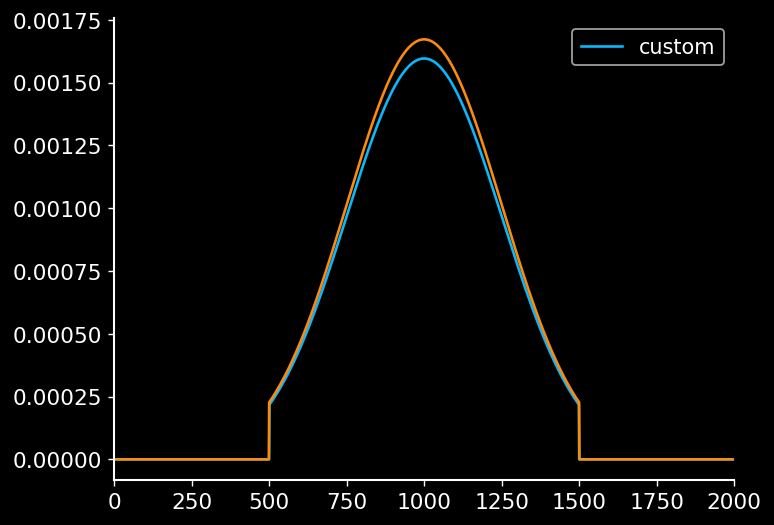

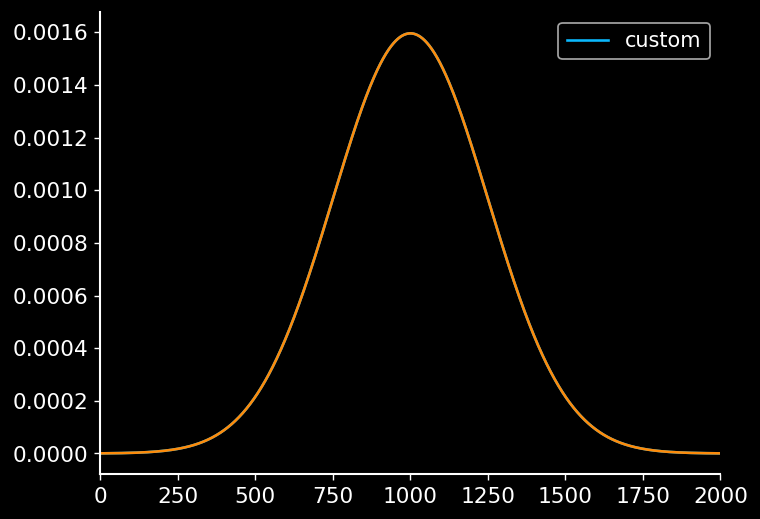

In [90]:
timesteps = np.arange(0,2000,1)
cut_off_a,cut_off_b = 500,1500
mu,sig = 1000,250
a, b = (cut_off_a - mu)/sig, (cut_off_b - mu) / sig
trunc = truncnorm(timesteps,cut_off_a,cut_off_b,mu,sig)
me = trunc.pdf()
me2 = trunc.norm_pdf()
them = stats.truncnorm.pdf(timesteps,a,b,mu,sig)
them2 = stats.norm.pdf(timesteps,mu,sig)
fig,ax = plt.subplots()
ax.plot(timesteps,me,label='custom')
ax.plot(timesteps,them)
ax.set_xlim(0,2000)
ax.legend()
fig,ax = plt.subplots()
ax.plot(timesteps,me2,label='custom')
ax.plot(timesteps,them2)
ax.set_xlim(0,2000)
ax.legend()

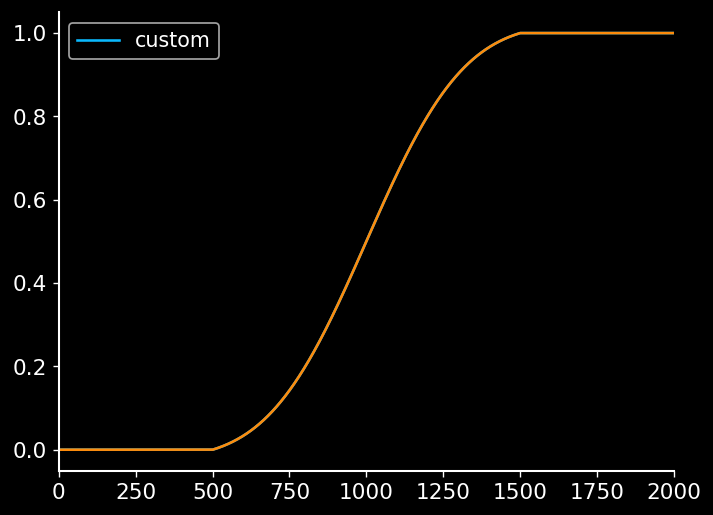

In [91]:
timesteps = np.arange(0,2000,1)
cut_off_a,cut_off_b = 500,1500
mu,sig = 1000,250
a, b = (cut_off_a - mu)/sig, (cut_off_b - mu) / sig

me = trunc.cdf()
them = stats.truncnorm.cdf(timesteps,a,b,mu,sig)
fig,ax = plt.subplots(dpi=124)
ax.plot(timesteps,me,label='custom')
ax.plot(timesteps,them)
ax.set_xlim(0,2000)
ax.legend()

Uncertain pdf

Instead of thinking about cutoff times, just get the distribution that gives the probability that the player cut off time will be greater than the agent's decision time

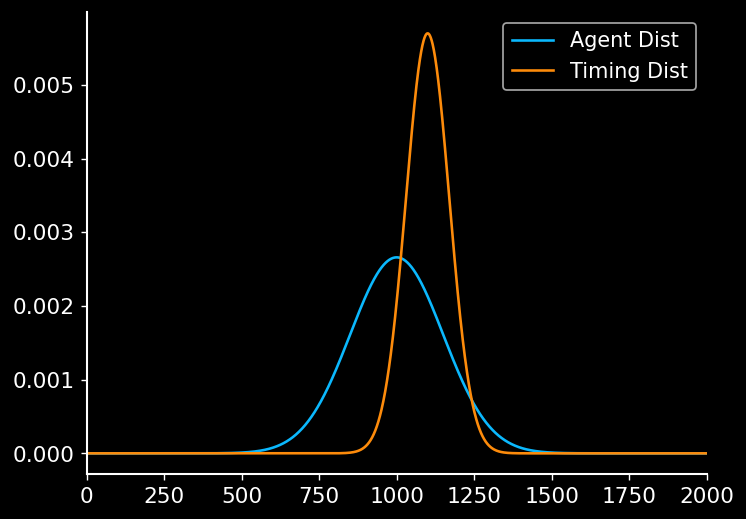

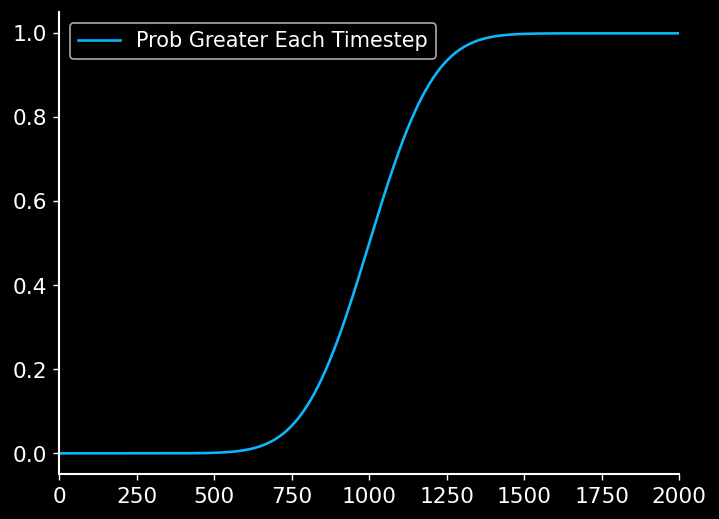

In [92]:
timesteps = np.arange(0,2000,1)
mu,sd = 1000,150
agent_dist = stats.norm.pdf(timesteps,mu,sd)

cut_time = 1100
timing_dist = stats.norm.pdf(timesteps,cut_time,70)

prob_greater = 1 - stats.norm.cdf(0,timesteps- mu,np.sqrt(sd**2+70**2))

fig,ax = plt.subplots(dpi=125)
ax.plot(timesteps,agent_dist,label='Agent Dist')
ax.plot(timesteps,timing_dist,label='Timing Dist')

ax.set_xlim(0,2000)

ax.legend()
plt.show()
fig,ax = plt.subplots(dpi=125)
ax.plot(timesteps,prob_greater,label='Prob Greater Each Timestep')
ax.set_xlim(0,2000)

ax.legend()
plt.show()



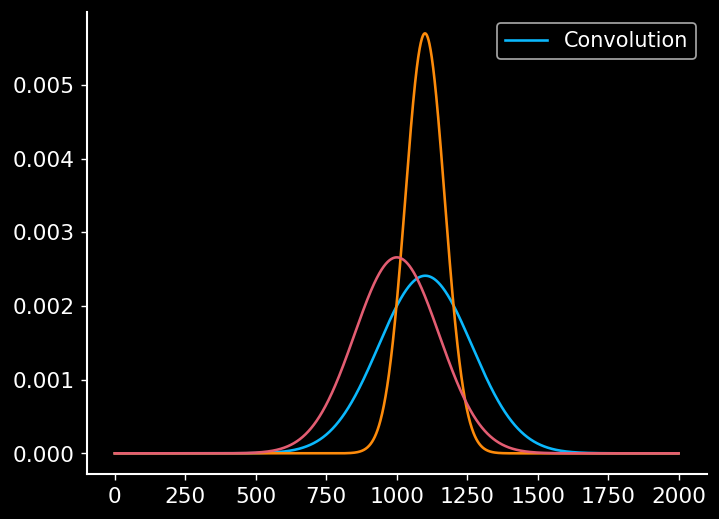

In [93]:
conv = signal.fftconvolve(agent_dist,timing_dist,mode='same')
conv2= signal.fftconvolve(timing_dist,agent_dist)
fig,ax = plt.subplots()
ax.plot(conv,label='Convolution')
ax.plot(timesteps,timing_dist)
# ax.plot(agent_dist*timing_dist/np.sum(agent_dist*timing_dist))
ax.plot(timesteps,agent_dist)
ax.legend()

Cut off with certain cut off time

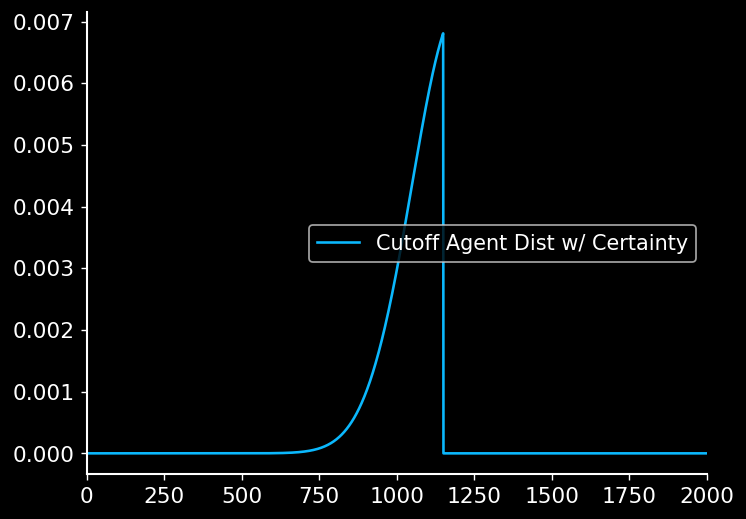

In [94]:
t = np.arange(0,2000,1)
cut_off_a =-np.inf
cut_off_b = 1150

mu,sd = 1200,150
a, b = (cut_off_a - mu)/sd, (cut_off_b - mu) / sd
norm_pdf = stats.norm.pdf(t,mu,sd)
cutoff_pdf_certain = stats.truncnorm.pdf(t,a,b,loc=mu,scale=sd) 
timing_pdf = stats.norm.pdf(t,)

fig,ax = plt.subplots(dpi=125)
ax.plot(t,cutoff_pdf_certain,label='Cutoff Agent Dist w/ Certainty')
ax.set_xlim(0,2000)

ax.legend()
plt.show()

In [95]:
x = stats.truncnorm.stats(a,b,loc=mu,scale=sd) 
x

(array(1046.77544715), array(6683.46404621))

Simulating 10000 truncnorm pdfs with the cut off time as the random variable

In [96]:
t = np.arange(0,2000,1)
mu,sd = 1200,150
cut_off_a,cut_off_b =-np.inf, 1200
iterations = 10000

every_pdf = np.zeros((iterations,len(t)))
cut_off_b_rvs = stats.norm.rvs(cut_off_b,70,iterations)
a, b, b_rvs = (cut_off_a - mu)/sd,(cut_off_b - mu) / sd, (cut_off_b_rvs - mu) / sd
for i in range(iterations):
    every_pdf[i,:] = stats.truncnorm.pdf(t,a,b_rvs[i],loc=mu,scale=sd)
cutoff_pdf_uncertain = np.mean(every_pdf,axis=0)
norm_pdf = stats.norm.pdf(t,mu,sd)
cutoff_pdf_certain = stats.truncnorm.pdf(t,a,b,loc=mu,scale=sd) 
mean_certain_cutoff = stats.truncnorm.stats(a,b,loc=mu,scale=sd,moments='m')



ValueError: x and y must have same first dimension, but have shapes (2000,) and (900,)

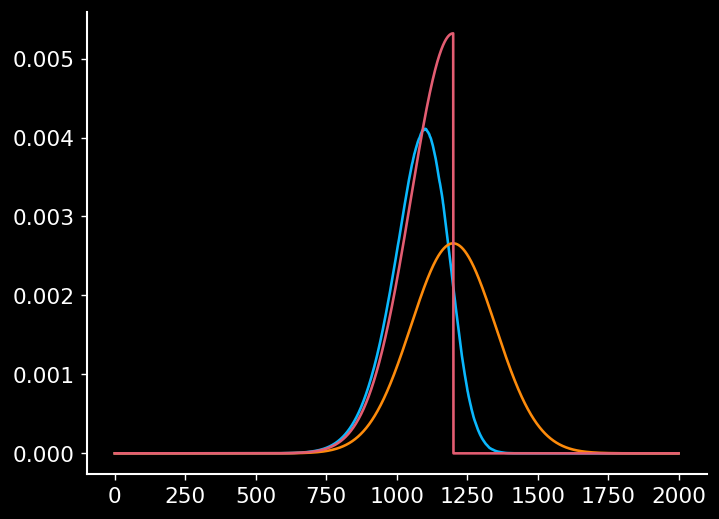

In [234]:
# timing_pdf_at_cutoff = stats.norm.pdf(t,cut_off_b,70) # Likelihood
# skewnorm = stats.skewnorm.pdf(t,-0.15,1068,sd-55)

fig,ax = plt.subplots(dpi=125)
ax.plot(t,cutoff_pdf_uncertain,label='cutoff pdf w/ uncertainty')
ax.plot(t,norm_pdf,label='agent_pdf')
ax.plot(t,cutoff_pdf_certain,label='cutoff certain')
# ax.plot(t,skewnorm,label='skewnorm')
# ax.plot(t,timing_pdf_at_cutoff,label='timing pdf')
# ax.plot(t,pdf)
# for i in range(100):
#     ax.plot(t,every_pdf[i,:])
# ax.set_xlim(0,2000)
# ax.axvline(x=1046)
ax.axvline(x=np.argmax(cutoff_pdf_uncertain))
ax.legend(fontsize=6)
plt.show()
print(np.argmax(cutoff_pdf_uncertain))
print(mean_certain_cutoff)


Can I do the convolution of timing pdf with agent pdf to get the new pdf that the person will see?

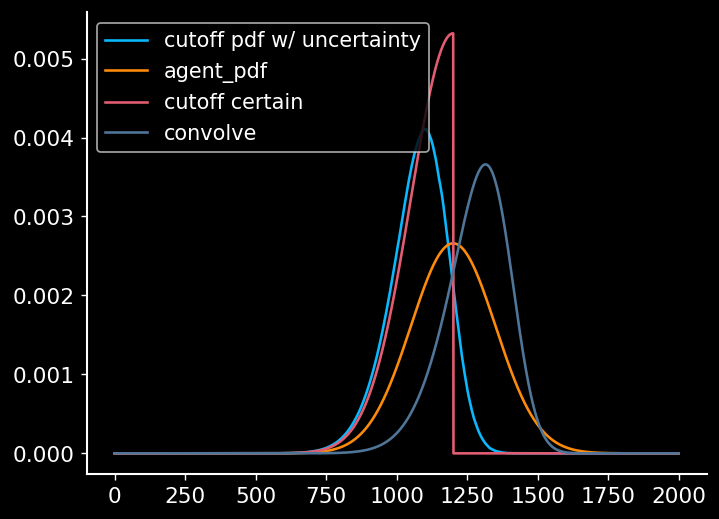

In [98]:
timing_pdf_at_cutoff = stats.norm.pdf(t,cut_off_b,70) # Likelihood
norm_pdf = stats.norm.pdf(t,mu,sd)
conv = signal.fftconvolve(timing_pdf_at_cutoff,norm_pdf,mode='same')
conv2 = signal.fftconvolve(cutoff_pdf_certain,norm_pdf,mode='same')
conv3 = signal.fftconvolve(timing_pdf_at_cutoff,cutoff_pdf_certain,mode='same')
fig,ax = plt.subplots(dpi=125)
ax.plot(t,cutoff_pdf_uncertain,label='cutoff pdf w/ uncertainty')
ax.plot(t,norm_pdf,label='agent_pdf')
ax.plot(t,cutoff_pdf_certain,label='cutoff certain')
ax.plot(conv3,label='convolve')
# ax.plot(t,timing_pdf_at_cutoff,label='timing pdf')

ax.legend()
plt.show()

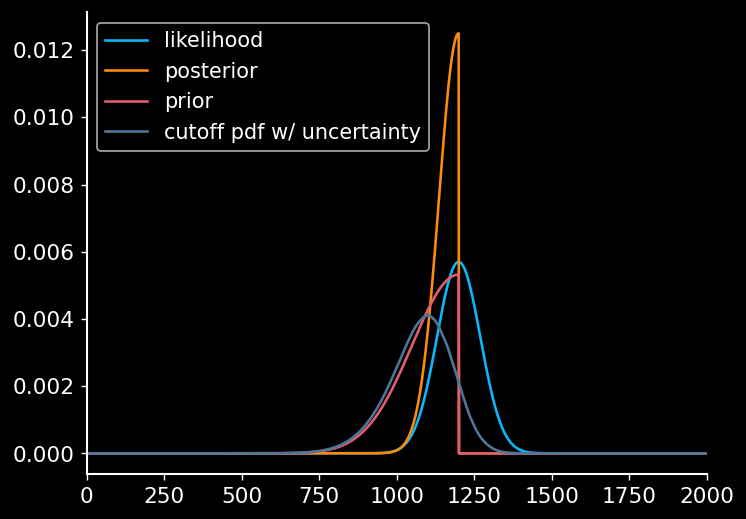

In [99]:
agent_pdf = stats.norm.pdf(t,mu,sd) # Prior
timing_pdf_at_cutoff = stats.norm.pdf(t,cut_off_b,70) # Likelihood
like = timing_pdf_at_cutoff
prior = cutoff_pdf_certain
like_norm = like/np.sum(like)
prior_norm = prior/np.sum(prior)
posterior = (like_norm*prior_norm)/np.sum(like_norm*prior_norm)
# cutoff_cdf_certain = stats.truncnorm.cdf(t,a,b,mu,sd)
fig,ax = plt.subplots(dpi=125)
ax.plot(t,like,label='likelihood')
# ax.plot(t,agent_pdf,label='agent')
ax.plot(t,posterior,label='posterior')
ax.plot(t,prior,label='prior')
ax.plot(t,cutoff_pdf_uncertain,label='cutoff pdf w/ uncertainty')
ax.set_xlim(0,2000)
ax.legend()
plt.show()



Convolution of hard cut off and soft cut off with reaction movement time

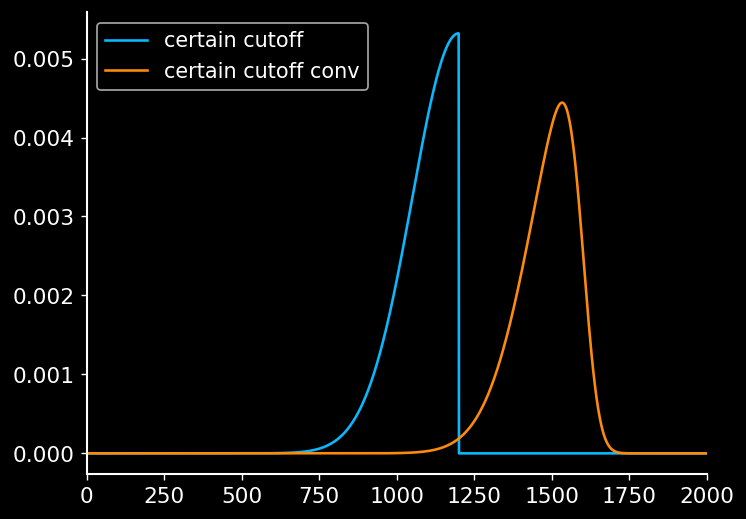

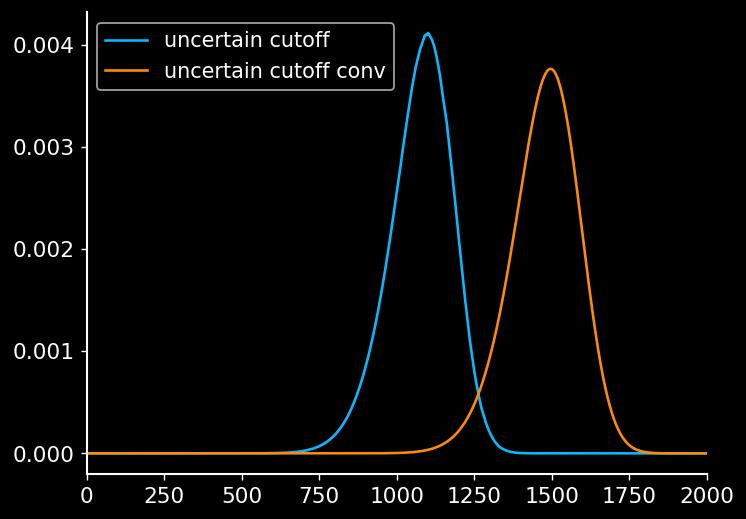

In [100]:
dx=1
rmt = stats.norm.pdf(t,400,40)
hard_rmt = signal.fftconvolve(cutoff_pdf_certain,rmt,mode='full') * dx
soft_rmt = signal.fftconvolve(cutoff_pdf_uncertain,rmt,mode = 'full')* dx
fig,ax = plt.subplots(dpi=125)
ax.plot(cutoff_pdf_certain,label='certain cutoff')
ax.plot(hard_rmt,label='certain cutoff conv')
ax.legend()
ax.set_xlim(0,2000)
plt.show()

fig,ax = plt.subplots(dpi=125)
ax.plot(cutoff_pdf_uncertain,label='uncertain cutoff')
ax.plot(soft_rmt,label='uncertain cutoff conv')
ax.legend()
ax.set_xlim(0,2000)
plt.show()

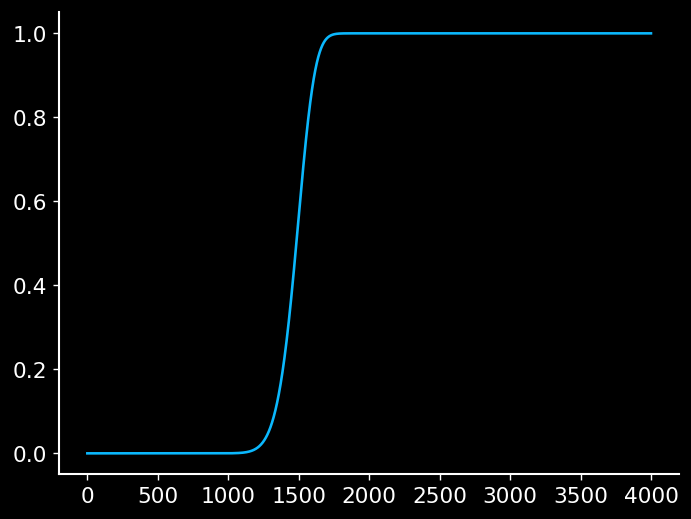

In [101]:
plt.plot(np.cumsum(soft_rmt))

Figure out how to simulate the uncertain distribution for each timestep

In [102]:
# iterations = 10000
# timesteps = np.arange(0,2000,1)
# timing_uncertainty = 70
# cut_off_a = -10000000
# every_pdf = np.zeros((iterations,2000))
# cut_off_b_rvs = stats.norm.rvs(timesteps,timing_uncertainty,size = (10000,2000))

# mu,sd = 1000,150
# a, b_rvs = (cut_off_a - mu)/sd, (cut_off_b_rvs - mu) / sd
# every_pdf = np.zeros((iterations,2000,2000))
# for i in range(iterations):
#     for k in range(len(timesteps)):
#         every_pdf[i,k,:] = stats.truncnorm.pdf(timesteps,a,cut_off_b_rvs[i,k],loc=mu,scale=sd)

MemoryError: Unable to allocate 298. GiB for an array with shape (10000, 2000, 2000) and data type float64

In [212]:
def screw_you_john(params,true_pdf):
    pdf_params = stats.skewnorm.pdf(t,params[0],params[1],params[2])
    log_params = np.log(pdf_params, out=np.zeros_like(pdf_params), where=(pdf_params!=0))
    log_true = np.log(true_pdf, out=np.zeros_like(true_pdf), where=(true_pdf!=0))
    mse = np.sum(np.abs(pdf_params-true_pdf))
    
    is_negative = params<=0
    if is_negative.any():
        return 1e6
    return mse

In [219]:
init_skew,init_mean,init_sd = 2,300,50
bnds = ((-10,10),(300,2000),(0,500))
t = np.arange(0,2000,1)
mu,sd = 1200,150
cut_off_a,cut_off_b =-np.inf, 1000
iterations = 10000

every_pdf = np.zeros((iterations,len(t)))
cut_off_b_rvs = stats.norm.rvs(cut_off_b,1,iterations)
a, b, b_rvs = (cut_off_a - mu)/sd,(cut_off_b - mu) / sd, (cut_off_b_rvs - mu) / sd
for i in range(iterations):
    every_pdf[i,:] = stats.truncnorm.pdf(t,a,b_rvs[i],loc=mu,scale=sd)
uncertain_trunc_pdf = np.mean(every_pdf,axis=0)

optim = optimize.minimize(screw_you_john,[init_skew,init_mean,init_sd],args=(uncertain_trunc_pdf),method='Nelder-Mead',bounds = bnds,
                          options = {"maxiter": 1e6,"maxfev": 1e6, "fatol":0.000000001,"disp": True})
optim.x

Optimization terminated successfully.
         Current function value: 0.463565
         Iterations: 720
         Function evaluations: 1221


array([9.34403814e-04, 9.49627723e+02, 5.23148955e+01])

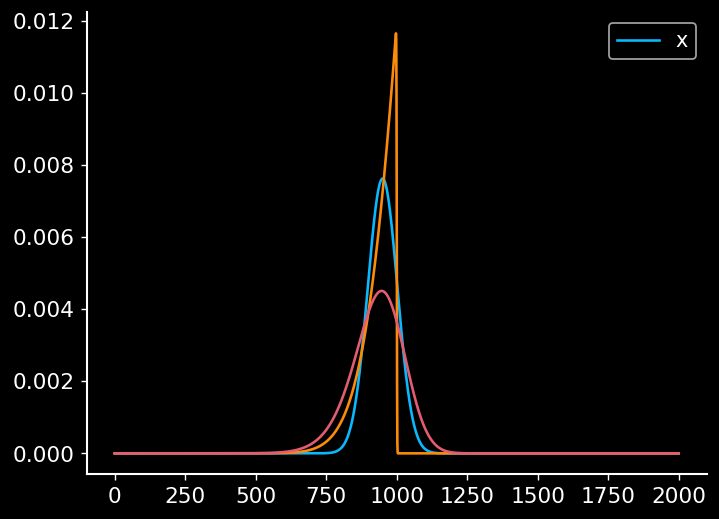

In [223]:
x = stats.skewnorm.pdf(t,optim.x[0],optim.x[1],optim.x[2])
fig,ax = plt.subplots()
plt.plot(x,label='x')
plt.plot(uncertain_trunc_pdf)
plt.plot(ndimage.gaussian_filter1d(uncertain_trunc_pdf,70))
ax.legend()

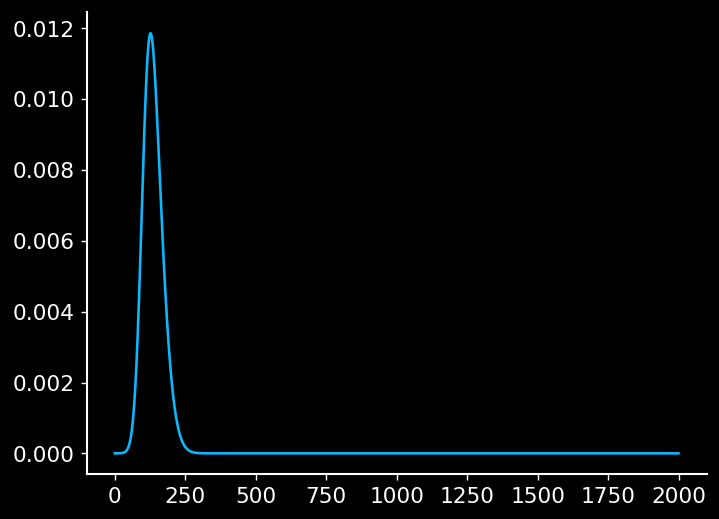

In [127]:
x = stats.skewnorm.pdf(t,2,100,50)
plt.plot(t,x)

C:\Users\Seth Sullivan\AppData\Local\Temp\ipykernel_103872\2071249266.py:1: RuntimeWarning: invalid value encountered in sqrt
  fit_pdf = stats.skewnorm.pdf(t,optim.x[0],optim.x[1],np.sqrt(optim.x[2]))


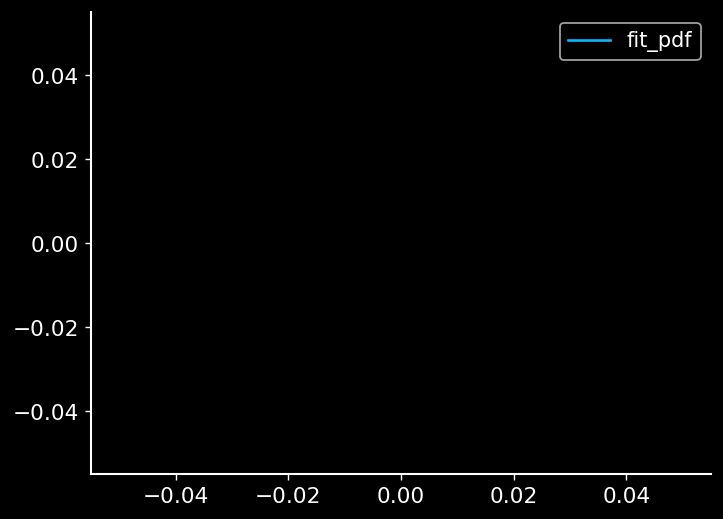

In [131]:
fit_pdf = stats.skewnorm.pdf(t,optim.x[0],optim.x[1],np.sqrt(optim.x[2]))
# fit_pdf = stats.skewnorm.pdf(t,1,2,10)
true_pdf = cutoff_pdf_uncertain

plt.show()
fig,ax = plt.subplots(dpi=125)
# ax.plot(true_pdf,label='true_pdf')
ax.plot(fit_pdf,label='fit_pdf')
ax.legend()

GAUSSIAN SMOOTHING

In [251]:
t = np.arange(0,2000,1)
mu,sd = 1200,150
cut_off_a,cut_off_b =-np.inf, 1200
iterations = 10000

every_pdf = np.zeros((iterations,len(t)))
cut_off_b_rvs = stats.norm.rvs(cut_off_b,70,iterations)
a, b, b_rvs = (cut_off_a - mu)/sd,(cut_off_b - mu) / sd, (cut_off_b_rvs - mu) / sd
for i in range(iterations):
    every_pdf[i,:] = stats.truncnorm.pdf(t,a,b_rvs[i],loc=mu,scale=sd)
cutoff_pdf_uncertain = np.mean(every_pdf,axis=0)
norm_pdf = stats.norm.pdf(t,mu,sd)
cutoff_pdf_certain = stats.truncnorm.pdf(t,a,b,loc=mu,scale=sd) 
mean_certain_cutoff = stats.truncnorm.stats(a,b,loc=mu,scale=sd,moments='m')

cut_max_id = np.argmax(cutoff_pdf_uncertain)

certain_cutoff_smoothed = ndimage.gaussian_filter1d(cutoff_pdf_certain,70)
# Idea is to only smooth from the cutoff onwards
certain_cutoff_smoothed_v2 = np.hstack((cutoff_pdf_certain[:cut_max_id],ndimage.gaussian_filter1d(cutoff_pdf_certain[cut_max_id:],70)))

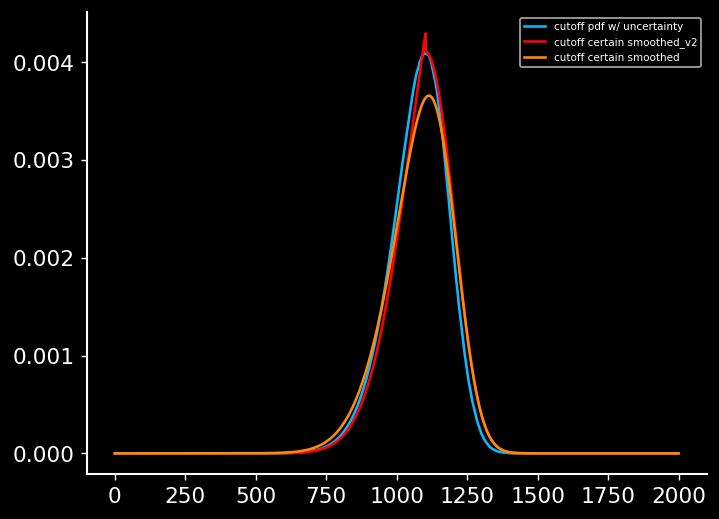

1103
1080.3173158795703


In [252]:
# timing_pdf_at_cutoff = stats.norm.pdf(t,cut_off_b,70) # Likelihood
# skewnorm = stats.skewnorm.pdf(t,-0.15,1068,sd-55)

fig,ax = plt.subplots(dpi=125)
# ax.plot(t,norm_pdf,label='agent_pdf')
# ax.plot(t,cutoff_pdf_certain,label='cutoff certain')
ax.plot(t,cutoff_pdf_uncertain,label='cutoff pdf w/ uncertainty')
ax.plot(t,certain_cutoff_smoothed_v2,label='cutoff certain smoothed_v2',color='red')
ax.plot(t,certain_cutoff_smoothed,label='cutoff certain smoothed')
# ax.plot(t,skewnorm,label='skewnorm')
# ax.plot(t,timing_pdf_at_cutoff,label='timing pdf')
# ax.plot(t,pdf)
# for i in range(100):
#     ax.plot(t,every_pdf[i,:])
# ax.set_xlim(0,2000)
# ax.axvline(x=1046)
# ax.axvline(x=np.argmax(cutoff_pdf_uncertain))
ax.legend(fontsize=6)
plt.show()
print(np.argmax(cutoff_pdf_uncertain))
print(mean_certain_cutoff)


In [ ]:
t = np.arange(0,2000,1)
mu,sd = 1200,150
cut_off_a,cut_off_b =-np.inf, 1200
iterations = 10000

every_pdf = np.zeros((iterations,len(t)))
cut_off_b_rvs = stats.norm.rvs(cut_off_b,70,iterations)
a, b, b_rvs = (cut_off_a - mu)/sd,(cut_off_b - mu) / sd, (cut_off_b_rvs - mu) / sd
for i in range(iterations):
    every_pdf[i,:] = stats.truncnorm.pdf(t,a,b_rvs[i],loc=mu,scale=sd)
cutoff_pdf_uncertain = np.mean(every_pdf,axis=0)
norm_pdf = stats.norm.pdf(t,mu,sd)
cutoff_pdf_certain = stats.truncnorm.pdf(t,a,b,loc=mu,scale=sd) 
mean_certain_cutoff = stats.truncnorm.stats(a,b,loc=mu,scale=sd,moments='m')

Simulating the agent's distribution with uncertain cutoff time

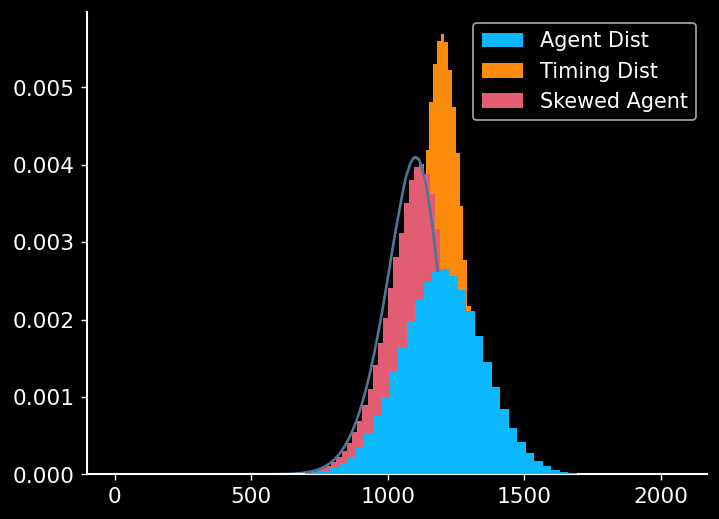

In [265]:
its = 1000000
rvs_agent = stats.norm.rvs(mu,sd,its)
rvs_timing = stats.norm.rvs(cut_off_b,70,its)

agent_mask = rvs_agent<rvs_timing

rvs_skewed_agent = rvs_agent*agent_mask
rvs_skewed_agent[~agent_mask] = np.nan

fig,ax = plt.subplots(dpi=125)
ax.hist(rvs_agent,bins=50,label='Agent Dist',density=True,zorder=10) 
ax.hist(rvs_timing,bins=50,label='Timing Dist',density=True)
ax.hist(rvs_skewed_agent,bins=50,label='Skewed Agent',density=True)   
ax.plot(cutoff_pdf_uncertain)
ax.legend()
plt.show()